In [ ]:
import glob
import os

import cv2
import numpy as np


class ImageReader:

    def __init__(self, train_path="/content/drive/MyDrive/IPML PROJECT/fracture-detection-main/fracture-detection-main/images/ml_eeeh_dataset", extension="jpg"):
        self.__train_path = train_path
        self.__extension = extension

    def read(self):
        tr_images, tr_labels = self._read_images_labels(self.__train_path,
                                                        self.__extension)
        return tr_images, tr_labels

    @staticmethod
    def _read_images_labels(path, extension):
        images = []
        labels = []
        # for directory_path in glob.glob("cell_images/original_train/*"):
        for directory_path in glob.glob(path + "/*"):
            label = directory_path.split("\\")[-1]
            for img_path in glob.glob(
                    os.path.join(directory_path, "*." + extension)
            ):
                # Reading color images
                img = cv2.imread(img_path , 0)
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Resize images
                img = cv2.resize(img, (256, 512))
                images.append(np.array(img))
                labels.append(label)

        return images, labels

In [ ]:
images, label = ImageReader._read_images_labels("/content/drive/MyDrive/IPML PROJECT/dataset_2/train","jpg")
images = np.array(images)
label = np.array(label)
print(images.shape)
print(label.shape)

(0,)
(0,)


In [ ]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops


class GLCM:
    def __init__(self, image):
        distance = [1, 3, 5, 8]
        angles = [
            0,  # 0
            np.pi / 4,  # 45
            np.pi / 2,  # 90
            3 * np.pi / 4,  # 135
            np.pi,  # 180
            5 * np.pi / 4,    # 225
            3 * np.pi / 2,    # 270
            7 * np.pi / 4     # 315
        ]
        self.glcm_mat = graycomatrix(image, distances=distance, angles=angles)
        self.properties = ['energy', 'correlation', 'dissimilarity',
                           'homogeneity', 'contrast']

    def correlation(self):
        return graycoprops(self.glcm_mat, 'correlation').flatten()

    def homogeneity(self):
        return graycoprops(self.glcm_mat, 'homogeneity').flatten()

    def contrast(self):
        return graycoprops(self.glcm_mat, 'contrast').flatten()

    def energy(self):
        return graycoprops(self.glcm_mat, 'energy').flatten()

    def dissimilarity(self):
        return graycoprops(self.glcm_mat, 'dissimilarity').flatten()

    def asm(self):
        return graycoprops(self.glcm_mat, 'ASM').flatten()

    def glcm_all(self):
        return np.hstack([graycoprops(self.glcm_mat, props).ravel() for props in
                          self.properties])

In [ ]:
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn import preprocessing

#import GLCM


class FeatureExtractor:

    def __init__(self, *args):
        if len(args) == 2:
            self.train_images = np.array(args[0])  # np.array(train_images)
            self.train_labels = np.array(args[1])  # np.array(train_labels)
            self._encode_labels()
        else:
            self._image = np.array(np.array(args[0]))

    def _encode_labels(self):
        # Encode labels from text (folder names) to integers.
        le = preprocessing.LabelEncoder()

        le.fit(self.train_labels)
        train_labels_encoded = le.transform(self.train_labels)
        self.train_labels = train_labels_encoded

    def glcm_feature_extraction(self):
        image_features = []
        for image in self.train_images:
            image_features.append(GLCM(image).glcm_all())
        return image_features, self.train_labels

    def single_glcm_feature_extraction(self):
        return GLCM(self._image).glcm_all()

In [ ]:
from enum import Enum, unique, auto

import cv2


@unique
class Filter(Enum):
    median = auto()
    gaussian = auto()
    equalize_hist = auto()
    adaptive_hist = auto()
    adjust_contrast = auto()
    canny = auto()
    sobel = auto()

    def __str__(self):
        return ' '.join(word.title() for word in self.name.split('_'))


class Preprocessors:

    def __init__(self, images):
        self._images = images

    def _median(self):
        for index, img in enumerate(self._images):
            self._images[index] = cv2.medianBlur(img, 3)

        return self

    def _gaussian(self):
        for index, img in enumerate(self._images):
            self._images[index] = cv2.GaussianBlur(img, (3, 3), 0)

        return self

    def _equalize_hist(self):
        for index, img in enumerate(self._images):
            self._images[index] = cv2.equalizeHist(img)

        return self

    def _adaptive_hist(self):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

        for index, img in enumerate(self._images):
            self._images[index] = clahe.apply(img)

        return self

    def _adjust_contrast(self, brightness=-15, contrast=30):
        for index, img in enumerate(self._images):
            self._images[index] = _apply_contrast(img, brightness, contrast)

        return self

    def _canny(self):
        for index, img in enumerate(self._images):
            self._images[index] = cv2.Canny(img, 100, 150)

        return self

    def _sobel(self):
        for index, img in enumerate(self._images):
            self._images[index] = cv2.Sobel(img, ddepth=cv2.CV_8U, dx=1,
                                            dy=0, ksize=3)

        return self

    def process(self, filters: [Filter]):
        for _filter in filters:
            if _filter == Filter.median:
                self._median()
            elif _filter == Filter.gaussian:
                self._gaussian()
            elif _filter == Filter.equalize_hist:
                self._equalize_hist()
            elif _filter == Filter.adaptive_hist:
                self._adaptive_hist()
            elif _filter == Filter.adjust_contrast:
                self._adjust_contrast()
            elif _filter == Filter.canny:
                self._canny()
            elif _filter == Filter.sobel:
                self._sobel()

        return self._images


def _apply_contrast(img, brightness, contrast):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255
        gamma_b = shadow

        buf = cv2.addWeighted(img, alpha_b, img, 0, gamma_b)
    else:
        buf = img.copy()

    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [ ]:
filters = [[Filter.canny]]
p_train_images = Preprocessors(images).process(filters)
_images, _labels = None, None
features = FeatureExtractor(p_train_images, label)
_images, _labels = features.glcm_feature_extraction()

_images = np.array(_images)
_label = np.array(_labels)


In [ ]:
print(_images.shape)
print(_label.shape)

(0,)
(0,)


In [ ]:
test_images, test_label = ImageReader._read_images_labels("/content/drive/MyDrive/IPML PROJECT/dataset_2/val","jpg")
test_images = np.array(test_images)
test_label = np.array(test_label)
print(test_images.shape)
print(test_label.shape)

(0,)
(0,)


In [ ]:
filters = [[Filter.canny]]
p_train_images = Preprocessors(test_images).process(filters)
_test_images, _test_labels = None, None
features = FeatureExtractor(p_train_images, test_label)
_test_images, _test_labels = features.glcm_feature_extraction()

_test_images = np.array(_test_images)
_test_labels = np.array(_test_labels)

In [ ]:
from enum import Enum, auto, unique
import cv2
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score




@unique
class DatasetType(Enum):
    EEEH = auto()
    Roboflow = auto()

@unique
class Ml(Enum):
    svm = auto()
    decision_tree = auto()
    naive_bayes = auto()
    random_forest = auto()
    nearest_neighbors = auto()
    logistic_regression = auto()
    kmeans = auto()  # Add KMeans
    gmm = auto()  # Add Gaussian Mixture Model (GMM)
    isolation_forest = auto()  # Add Isolation Forest

    def __str__(self):
        return ' '.join(word.title() for word in self.name.split('_'))

class FractureDetector:
    #def __init__(self, filters: [Filter], ml: Ml, dataset=DatasetType.EEEH):
    def __init__(self, filters: [Filter], ml: Ml):
        #self._dataset = dataset
        global _images
        global _labels
        global _test_images
        global _test_label
        self._filters = filters
        self._ml = ml
        if _images is None or _labels is None or _test_images is None or _test_labels is None:
            train_reader = ImageReader(train_path="/content/drive/MyDrive/IPML PROJECT/dataset_2/train")

            test_reader = ImageReader(train_path="/content/drive/MyDrive/IPML PROJECT/dataset_2/val")

            self._train_images, self._train_labels = train_reader.read()
            self._test_images, self._test_labels = test_reader.read()
            """if dataset == DatasetType.EEEH:
                reader = ImageReader(train_path="/content/drive/MyDrive/IPML PROJECT/fracture-detection-main/fracture-detection-main/images/ml_eeeh_dataset")
            elif dataset == DatasetType.Roboflow:
                reader = ImageReader(train_path="/content/drive/MyDrive/IPML PROJECT/fracture-detection-main/fracture-detection-main/images/ml_roboflow_dataset")
            else:
                reader = ImageReader()

            o_train_images, o_train_labels = reader.read()
            p_train_images = Preprocessors(o_train_images).process(filters)

            features = FeatureExtractor(p_train_images, o_train_labels)"""
            p_train_images = Preprocessors(self._train_images).process(filters)

            features = FeatureExtractor(p_train_images, self._train_labels)
            self._images, self._labels = features.glcm_feature_extraction()
        else:
            self._images = _images
            self._labels = _labels
            self._test_images = _test_images
            self._test_labels = _test_labels
        """
        self._train_images, self._test_images, self._train_labels, self._test_labels = model_selection.train_test_split(
            self._images, self._labels, test_size=0.2,
            random_state=0)
        """

        self._clf = self._get_clf()

    def _get_clf(self):
        self._train_images = np.array(self._images)
        self._train_labels = np.array(self._labels)
        if self._ml == Ml.svm:
            clf = SVC(kernel="rbf", C=10000)
            return clf.fit(self._train_images, self._train_labels)
        elif self._ml == Ml.decision_tree:
            clf = DecisionTreeClassifier(min_samples_split=40)
            return clf.fit(self._train_images, self._train_labels)
        elif self._ml == Ml.naive_bayes:
            clf = GaussianNB()
            return clf.fit(self._train_images, self._train_labels)
        elif self._ml == Ml.random_forest:
            clf = RandomForestClassifier(no)
            return clf.fit(self._train_images, self._train_labels)
        elif self._ml == Ml.nearest_neighbors:
            clf = KNeighborsClassifier(n_neighbors=30)
            return clf.fit(self._train_images, self._train_labels)
        elif self._ml == Ml.logistic_regression:
            clf = LogisticRegression()
            return clf.fit(self._train_images, self._train_labels)
        elif self._ml == Ml.kmeans:  # Implement KMeans
            clf = KMeans(n_clusters=2)
            return clf.fit(self._train_images)
        elif self._ml == Ml.gmm:  # Implement Gaussian Mixture Model (GMM)
            clf = GaussianMixture(n_components=2)
            return clf.fit(self._train_images)
        elif self._ml == Ml.isolation_forest:  # Implement Isolation Forest
            clf = IsolationForest()
            return clf.fit(self._train_images)

    def predict(self, img_path: str, img_size=128):
        read_img = cv2.imread(img_path, 0)
        resize_img = cv2.resize(read_img, (img_size, img_size))
        processed_img = Preprocessors([resize_img]).process(self._filters)
        features = FeatureExtractor(processed_img)
        img_features = features.single_glcm_feature_extraction()
        predict = self._clf.predict(img_features) if self._ml != Ml.kmeans else self._clf.predict([img_features])
        predict_label = ['Fractured', 'Non-Fractured']

        data = []
        data.extend(self._filters)
        data.append(self._ml)
        data.append(predict_label[predict[0]])
        return data

    """
    def accuracy(self):
        data = []
        data.append(self._dataset.name)
        data.append(self._ml)
        predicted = self._clf.predict(self._test_images) if self._ml != Ml.kmeans else self._clf.predict(self._test_images)  # Handle KMeans prediction differently
        result = metrics.classification_report(self._test_labels, predicted,
                                               output_dict=True)
        data.append(result['weighted avg']['precision'])
        data.append(result['weighted avg']['recall'])
        data.append(result['accuracy'])
        return data"""
    def accuracy(self):
        data = []
        #data.append(self._dataset.name)
        data.append(self._ml)
        predicted = self._clf.predict(self._test_images) if self._ml != Ml.kmeans else self._clf.predict(self._test_images)  # Handle KMeans prediction differently

        result = classification_report(self._test_labels, predicted, output_dict=True, zero_division=0)
        accuracy = accuracy_score(self._test_labels, predicted)
        f1 = f1_score(self._test_labels, predicted, average='weighted', zero_division=0)

        precision = result['weighted avg']['precision']
        recall = result['weighted avg']['recall']
        # Avoid warnings for 0 precision and recall
        if precision == 0 and recall == 0:
            precision = recall = 0
        data.extend([precision, recall, accuracy, f1, self._test_labels, predicted])  # Append true labels and predicted labels
        return data


    @staticmethod
    def train_and_test(filters):
        return[
            FractureDetector(filters, Ml.svm).accuracy(),

            FractureDetector(filters, Ml.decision_tree).accuracy(),

            FractureDetector(filters, Ml.naive_bayes).accuracy(),

            FractureDetector(filters, Ml.random_forest).accuracy(),

            FractureDetector(filters, Ml.nearest_neighbors).accuracy(),

            FractureDetector(filters, Ml.logistic_regression).accuracy(),

            FractureDetector(filters, Ml.kmeans).accuracy(),

            FractureDetector(filters, Ml.gmm).accuracy()
        ]
        """
        return [
            FractureDetector(filters, Ml.svm,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.svm,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.decision_tree,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.decision_tree,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.naive_bayes,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.naive_bayes,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.random_forest,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.random_forest,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.nearest_neighbors,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.nearest_neighbors,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.logistic_regression,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.logistic_regression,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.kmeans,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.kmeans,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.gmm,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.gmm,
                             dataset=DatasetType.Roboflow).accuracy(),
            FractureDetector(filters, Ml.isolation_forest,
                             dataset=DatasetType.EEEH).accuracy(),
            FractureDetector(filters, Ml.isolation_forest,
                             dataset=DatasetType.Roboflow).accuracy(),
        ]"""


In [ ]:
from tabulate import tabulate

def print_table(data):
    headers = ['ML Algorithm', 'Precision', 'Recall', 'Accuracy', 'F1 Score']
    rows = []
    for result in data:
        row = [result[0], result[1], result[2], result[3], result[4]]
        rows.append(row)
    print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))


In [ ]:
"""def main():
    filters = [[Filter.gaussian, Filter.adaptive_hist, Filter.canny]]
    data = []
    for _filter in filters:
        for ml_algorithm in Ml:
            for dataset in DatasetType:
                if ml_algorithm != Ml.kmeans and dataset != DatasetType.Roboflow:
                    detector = FractureDetector(_filter, ml_algorithm,
                                                dataset=dataset)
                    data.append(detector.accuracy())
                elif ml_algorithm == Ml.kmeans and dataset != DatasetType.Roboflow:
                    detector = FractureDetector(_filter, ml_algorithm,
                                                dataset=dataset)
                    data.append(detector.accuracy())
                elif ml_algorithm == Ml.kmeans and dataset == DatasetType.Roboflow:
                    continue
                else:
                    continue

    print("ML Comparison Table")
    print_table(data)


if __name__ == "__main__":
    main()"""

'def main():\n    filters = [[Filter.gaussian, Filter.adaptive_hist, Filter.canny]]\n    data = []\n    for _filter in filters:\n        for ml_algorithm in Ml:\n            for dataset in DatasetType:\n                if ml_algorithm != Ml.kmeans and dataset != DatasetType.Roboflow:\n                    detector = FractureDetector(_filter, ml_algorithm,\n                                                dataset=dataset)\n                    data.append(detector.accuracy())\n                elif ml_algorithm == Ml.kmeans and dataset != DatasetType.Roboflow:\n                    detector = FractureDetector(_filter, ml_algorithm,\n                                                dataset=dataset)\n                    data.append(detector.accuracy())\n                elif ml_algorithm == Ml.kmeans and dataset == DatasetType.Roboflow:\n                    continue\n                else:\n                    continue\n\n    print("ML Comparison Table")\n    print_table(data)\n\n\nif __name__ ==

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tabulate import tabulate

def evaluate_results(data):
    results_to_display = []
    for result in data:
        precision, recall, accuracy, f1 = result[1], result[2], result[3], result[4]
        if recall > 0.5 or f1 > 0.5 or accuracy > 0.5:
            print("ML Algorithm:", result[0])
            print("Precision:", precision)
            print("Recall:", recall)
            print("Accuracy:", accuracy)
            print("F1 Score:", f1)

            # Compute confusion matrix
            print(result[5])
            print(result[6])
            tn, fp, fn, tp = confusion_matrix(result[5], result[6]).ravel()
            print("Confusion Matrix:")
            print("TN:", tn, "FP:", fp)
            print("FN:", fn, "TP:", tp)

            # Compute ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(result[5], result[6])
            auc = roc_auc_score(result[5], result[6])
            print("AUC:", auc)

            # Tabulate results
            results_to_display.append([result[0], precision, recall, accuracy, f1, auc])

            # Plot ROC curve
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc="lower right")
            plt.show()

    # Print tabulated results
    print("\nTabulated Results:")
    print(tabulate(results_to_display,
                   headers=['ML Algorithm', 'Precision', 'Recall', 'Accuracy', 'F1 Score', 'AUC'],
                   tablefmt="fancy_grid"))


In [ ]:


data = None
def main():
    global data
    filters = [[Filter.gaussian, Filter.adaptive_hist, Filter.canny]]
    data = FractureDetector.train_and_test(filters)
    print("ML Comparison Table")
    print_table(data)


if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ML Comparison Table
╒═════════════════════╤═════════════╤══════════╤════════════╤════════════╕
│ ML Algorithm        │   Precision │   Recall │   Accuracy │   F1 Score │
╞═════════════════════╪═════════════╪══════════╪════════════╪════════════╡
│ Svm                 │    0.750895 │ 0.67     │   0.67     │   0.666193 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Decision Tree       │    0.657523 │ 0.636667 │   0.636667 │   0.64033  │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Naive Bayes         │    0.781962 │ 0.726667 │   0.726667 │   0.727186 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Random Forest       │    0.819646 │ 0.811667 │   0.811667 │   0.813201 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Nearest Neighbors   │    0.65978  │ 0.59     │   0.59     │   0.584862 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Log

ML Algorithm: Svm
Precision: 0.7508947675549504
Recall: 0.67
Accuracy: 0.67
F1 Score: 0.6661930426261636
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

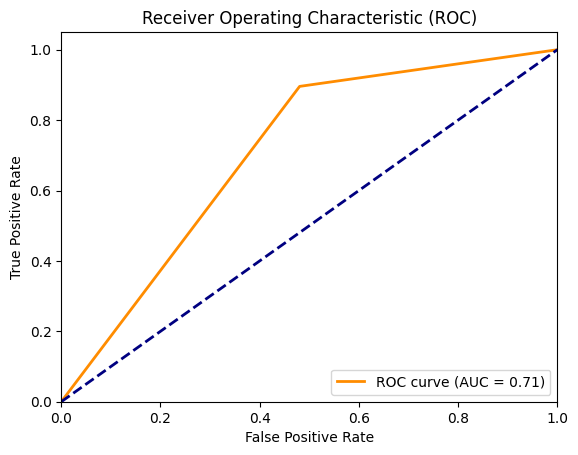

ML Algorithm: Decision Tree
Precision: 0.6575225565580692
Recall: 0.6366666666666667
Accuracy: 0.6366666666666667
F1 Score: 0.640330196615036
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

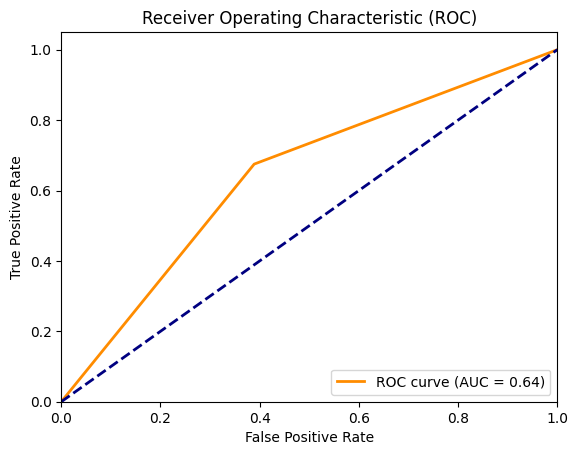

ML Algorithm: Naive Bayes
Precision: 0.7819622433512471
Recall: 0.7266666666666667
Accuracy: 0.7266666666666667
F1 Score: 0.7271860519385271
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

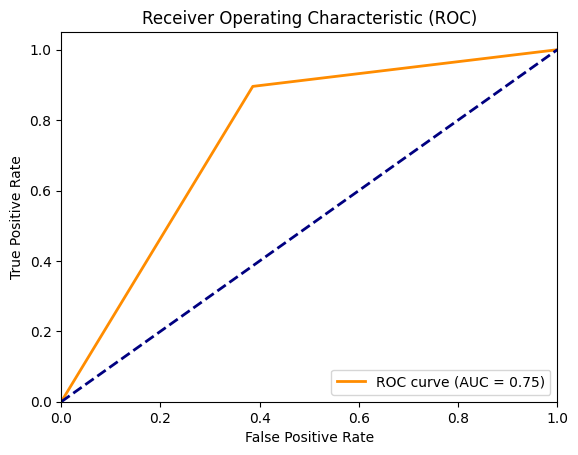

ML Algorithm: Random Forest
Precision: 0.819645797627449
Recall: 0.8116666666666666
Accuracy: 0.8116666666666666
F1 Score: 0.8132008818747499
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

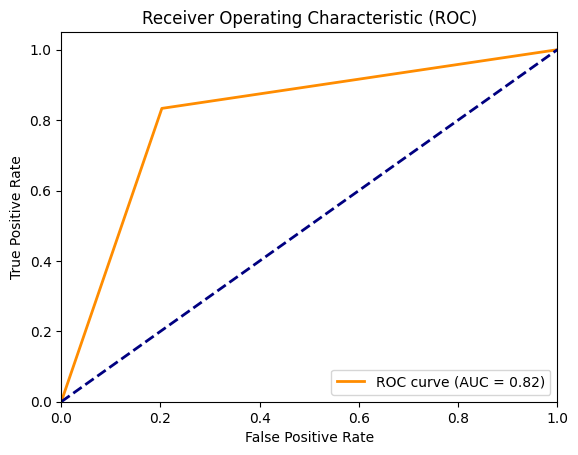

ML Algorithm: Nearest Neighbors
Precision: 0.6597802197802197
Recall: 0.59
Accuracy: 0.59
F1 Score: 0.5848621553884712
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

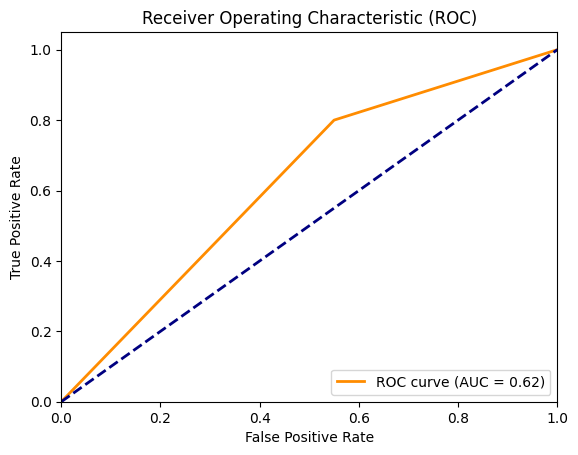

ML Algorithm: Logistic Regression
Precision: 0.7579847543398887
Recall: 0.5933333333333334
Accuracy: 0.5933333333333334
F1 Score: 0.5654000986340333
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0

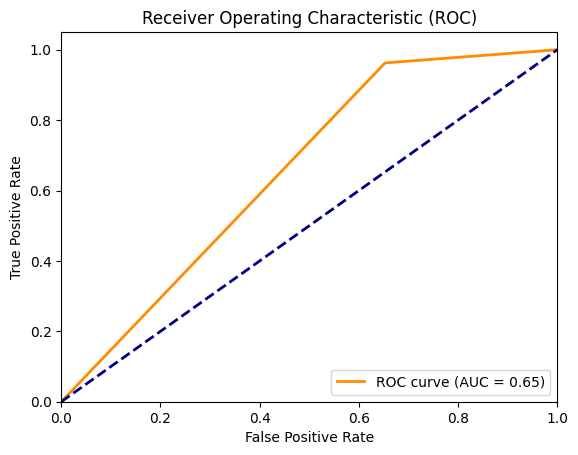

ML Algorithm: Kmeans
Precision: 0.8166760184042197
Recall: 0.715
Accuracy: 0.715
F1 Score: 0.7100700459441138
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

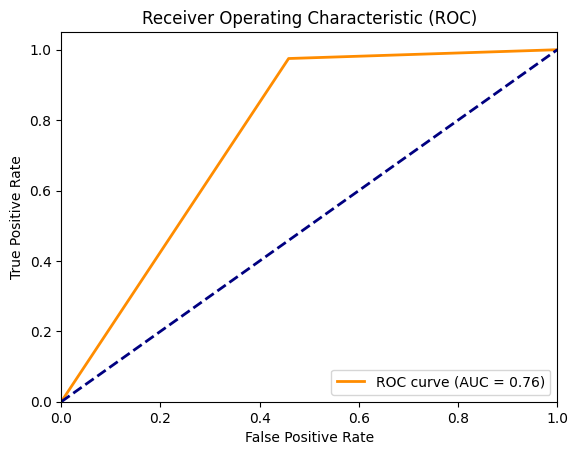


Tabulated Results:
╒═════════════════════╤═════════════╤══════════╤════════════╤════════════╤══════════╕
│ ML Algorithm        │   Precision │   Recall │   Accuracy │   F1 Score │      AUC │
╞═════════════════════╪═════════════╪══════════╪════════════╪════════════╪══════════╡
│ Svm                 │    0.750895 │ 0.67     │   0.67     │   0.666193 │ 0.707639 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┼──────────┤
│ Decision Tree       │    0.657523 │ 0.636667 │   0.636667 │   0.64033  │ 0.643056 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┼──────────┤
│ Naive Bayes         │    0.781962 │ 0.726667 │   0.726667 │   0.727186 │ 0.754861 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┼──────────┤
│ Random Forest       │    0.819646 │ 0.811667 │   0.811667 │   0.813201 │ 0.815278 │
├─────────────────────┼─────────────┼──────────┼────────────┼────────────┼──────────┤
│ Nearest Neighbors   │    0.65978

In [ ]:
evaluate_results(data)

In [ ]:
"""def main():
    filters = [Filter.gaussian, Filter.adaptive_hist, Filter.canny]
    data = []
    for _filter in filters:
        data = []
        detector = FractureDetector(_filter, Ml.svm)
        data.append(detector.accuracy())

        print("ML Comparison Table for "+str(_filter))
        print_table(data)
        evaluate_results(data)

    print("ML Comparison Table")
    print_table(data)
    evaluate_results(data)


if __name__ == "__main__":
    main()
"""


'def main():\n    filters = [Filter.gaussian, Filter.adaptive_hist, Filter.canny]\n    data = []\n    for _filter in filters:\n        data = []\n        detector = FractureDetector(_filter, Ml.svm)\n        data.append(detector.accuracy())\n\n        print("ML Comparison Table for "+str(_filter))\n        print_table(data)\n        evaluate_results(data)\n\n    print("ML Comparison Table")\n    print_table(data)\n    evaluate_results(data)\n\n\nif __name__ == "__main__":\n    main()\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import glob
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from skimage.feature import graycomatrix, graycoprops
import os

class ImageReader:
    def __init__(self, train_path, extension="jpg"):
        self.train_path = train_path
        self.extension = extension

    def read_images_labels(self):
        images = []
        labels = []
        label_map = {'not fractured': 0, 'fractured': 1}  # Map directory names to labels
        for folder_name in os.listdir(self.train_path):
            folder_path = os.path.join(self.train_path, folder_name)
            if os.path.isdir(folder_path):
                label = label_map.get(folder_name.lower())  # Ensure folder name is correctly mapped
                if label is None:
                    continue  # Skip folders not in label_map
                for img_path in glob.glob(os.path.join(folder_path, "*." + self.extension)):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 512))
                    images.append(img)
                    labels.append(label)
        return np.array(images), np.array(labels)

class FeatureExtractor:
    def __init__(self, images):
        self.images = images

    def extract_features(self):
        features = []
        angles_ = [
            0,  # 0
            np.pi / 4,  # 45
            np.pi / 2,  # 90
            3 * np.pi / 4,  # 135
            np.pi,  # 180
            5 * np.pi / 4,    # 225
            3 * np.pi / 2,    # 270
            7 * np.pi / 4     # 315
        ]
        for image in self.images:
            glcm_mat = graycomatrix(image, distances=[1, 3, 5, 8], angles=angles_)
            properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']
            feature = [graycoprops(glcm_mat, prop).ravel()[0] for prop in properties]
            features.append(feature)
        return np.array(features)

def main():
    train_path="/content/drive/MyDrive/IPML PROJECT/dataset_2/train"
    reader = ImageReader(train_path=train_path)
    images, labels = reader.read_images_labels()

    extractor = FeatureExtractor(images)
    features = extractor.extract_features()

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [40,50,60,70,80,90,100],  # Different numbers of estimators to try
    }

    # Initialize the random forest classifier
    clf = RandomForestClassifier(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)

    # Get the best estimator from grid search
    best_clf = grid_search.best_estimator_

    joblib.dump(best_clf, 'random_forest_model.pkl')
    print("Model saved successfully as 'random_forest_model.pkl'.")

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)

    # Evaluate on test set
    y_pred = best_clf.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("AUC:", auc)
    print("Confusion Matrix:")
    print(conf_matrix)

if __name__ == "__main__":
    main()


Model saved successfully as 'random_forest_model.pkl'.
Best parameters: {'n_estimators': 80}
Accuracy: 0.8945686900958466
Recall: 0.8545994065281899
AUC: 0.959950643926905
Confusion Matrix:
[[824  67]
 [ 98 576]]


Accuracy: 0.77
Recall: 0.7611111111111111
AUC: 0.8184664351851851
Confusion Matrix:
[[188  52]
 [ 86 274]]


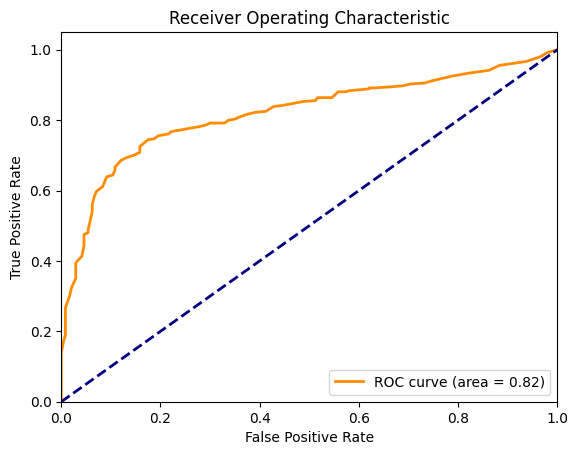

In [ ]:
import numpy as np
import cv2
import glob
import joblib
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from skimage.feature import graycomatrix, graycoprops
import os

class ImageReader:
    def __init__(self, test_path, extension="jpg"):
        self.test_path = test_path
        self.extension = extension

    def read_images_labels(self):
        images = []
        labels = []
        label_map = {'not fractured': 0, 'fractured': 1}  # Map directory names to labels
        for folder_name in os.listdir(self.test_path):
            folder_path = os.path.join(self.test_path, folder_name)
            if os.path.isdir(folder_path):
                label = label_map.get(folder_name.lower())  # Ensure folder name is correctly mapped
                if label is None:
                    continue  # Skip folders not in label_map
                for img_path in glob.glob(os.path.join(folder_path, "*." + self.extension)):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 512))
                    images.append(img)
                    labels.append(label)
        return np.array(images), np.array(labels)

class FeatureExtractor:
    def __init__(self, images):
        self.images = images

    def extract_features(self):
        features = []
        for image in self.images:
            glcm_mat = graycomatrix(image, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])
            properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']
            feature = [graycoprops(glcm_mat, prop).ravel()[0] for prop in properties]
            features.append(feature)
        return np.array(features)

def main():
    test_path = "/content/drive/MyDrive/IPML PROJECT/dataset_2/val"
    reader = ImageReader(test_path=test_path)
    images, labels = reader.read_images_labels()

    # Load the trained model
    clf = joblib.load('random_forest_model.pkl')

    extractor = FeatureExtractor(images)
    features = extractor.extract_features()

    # Predict on test set
    y_pred = clf.predict(features)

    # Calculate metrics
    accuracy = accuracy_score(labels, y_pred)
    recall = recall_score(labels, y_pred)
    auc_score = roc_auc_score(labels, clf.predict_proba(features)[:, 1])
    conf_matrix = confusion_matrix(labels, y_pred)

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(labels, clf.predict_proba(features)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    main()


Model saved successfully as 'random_forest_model.pkl'.
Best parameters: {'n_estimators': 77}
Best parameters: {'n_estimators': 77}
Accuracy: 0.8765578635014837
Recall: 0.8518518518518519
AUC: 0.9481612119192849
Confusion Matrix:
[[1666  192]
 [ 224 1288]]


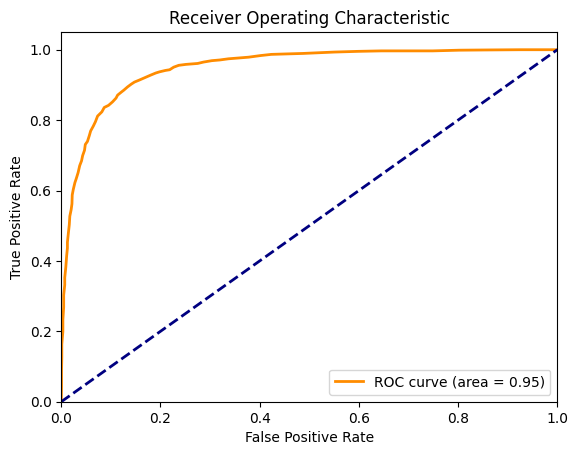

In [ ]:
import numpy as np
import cv2
import glob
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from skimage.feature import graycomatrix, graycoprops
import os

class ImageReader:
    def __init__(self, train_path, test_path, extension="jpg"):
        self.train_path = train_path
        self.test_path = test_path
        self.extension = extension

    def read_images_labels(self):
        images = []
        labels = []
        label_map = {'not fractured': 0, 'fractured': 1}  # Map directory names to labels

        # Read original training data
        for folder_name in os.listdir(self.train_path):
            folder_path = os.path.join(self.train_path, folder_name)
            if os.path.isdir(folder_path):
                label = label_map.get(folder_name.lower())  # Ensure folder name is correctly mapped
                if label is None:
                    continue  # Skip folders not in label_map
                for img_path in glob.glob(os.path.join(folder_path, "*." + self.extension)):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 512))
                    images.append(img)
                    labels.append(label)

        # Read test data
        for folder_name in os.listdir(self.test_path):
            folder_path = os.path.join(self.test_path, folder_name)
            if os.path.isdir(folder_path):
                label = label_map.get(folder_name.lower())  # Ensure folder name is correctly mapped
                if label is None:
                    continue  # Skip folders not in label_map
                for img_path in glob.glob(os.path.join(folder_path, "*." + self.extension)):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 512))
                    images.append(img)
                    labels.append(label)

        return np.array(images), np.array(labels)

class FeatureExtractor:
    def __init__(self, images):
        self.images = images

    def extract_features(self):
        features = []
        for image in self.images:
            glcm_mat = graycomatrix(image, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])
            properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']
            feature = [graycoprops(glcm_mat, prop).ravel()[0] for prop in properties]
            features.append(feature)
        return np.array(features)

def main():
    train_path = "/content/drive/MyDrive/IPML PROJECT/dataset_2/train"
    test_path = "/content/drive/MyDrive/IPML PROJECT/dataset_2/val"

    reader = ImageReader(train_path=train_path, test_path=test_path)
    images, labels = reader.read_images_labels()

    # Split the combined data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

    extractor = FeatureExtractor(X_train)
    X_train_features = extractor.extract_features()

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [75,76,77,78,79,80,81,82,83,84,82],  # Different numbers of estimators to try
    }

    # Initialize the random forest classifier
    clf = RandomForestClassifier(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='recall_weighted')
    grid_search.fit(X_train_features, y_train)

    # Get the best estimator from grid search
    best_clf = grid_search.best_estimator_

    joblib.dump(best_clf, 'random_forest_model.pkl')
    print("Model saved successfully as 'random_forest_model.pkl'.")

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)

    # Get the best estimator from grid search
    best_clf = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)

    # Evaluate on test set
    extractor = FeatureExtractor(X_test)
    X_test_features = extractor.extract_features()
    y_pred = best_clf.predict(X_test_features)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, best_clf.predict_proba(X_test_features)[:, 1])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, best_clf.predict_proba(X_test_features)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    main()


Model saved successfully as 'random_forest_model.pkl'.
Best parameters: {'n_estimators': 84}
Best parameters: {'n_estimators': 84}
Accuracy: 0.8890207715133531
Recall: 0.8597883597883598
AUC: 0.955741224847791
Confusion Matrix:
[[848  81]
 [106 650]]


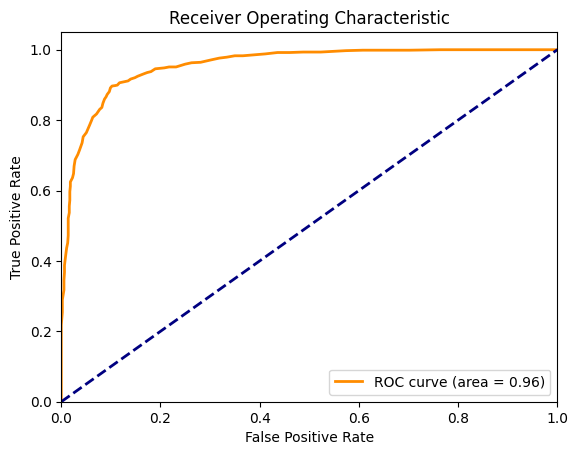

In [ ]:
import numpy as np
import cv2
import glob
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from skimage.feature import graycomatrix, graycoprops
import os

class ImageReader:
    def __init__(self, train_path, test_path, extension="jpg"):
        self.train_path = train_path
        self.test_path = test_path
        self.extension = extension

    def read_images_labels(self):
        images = []
        labels = []
        label_map = {'not fractured': 0, 'fractured': 1}  # Map directory names to labels

        # Read original training data
        for folder_name in os.listdir(self.train_path):
            folder_path = os.path.join(self.train_path, folder_name)
            if os.path.isdir(folder_path):
                label = label_map.get(folder_name.lower())  # Ensure folder name is correctly mapped
                if label is None:
                    continue  # Skip folders not in label_map
                for img_path in glob.glob(os.path.join(folder_path, "*." + self.extension)):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 512))
                    images.append(img)
                    labels.append(label)

        # Read test data
        for folder_name in os.listdir(self.test_path):
            folder_path = os.path.join(self.test_path, folder_name)
            if os.path.isdir(folder_path):
                label = label_map.get(folder_name.lower())  # Ensure folder name is correctly mapped
                if label is None:
                    continue  # Skip folders not in label_map
                for img_path in glob.glob(os.path.join(folder_path, "*." + self.extension)):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 512))
                    images.append(img)
                    labels.append(label)

        return np.array(images), np.array(labels)

class FeatureExtractor:
    def __init__(self, images):
        self.images = images

    def extract_features(self):
        features = []
        for image in self.images:
            glcm_mat = graycomatrix(image, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])
            properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']
            feature = [graycoprops(glcm_mat, prop).ravel()[0] for prop in properties]
            features.append(feature)
        return np.array(features)

def main():
    train_path = "/content/drive/MyDrive/IPML PROJECT/dataset_2/train"
    test_path = "/content/drive/MyDrive/IPML PROJECT/dataset_2/val"

    reader = ImageReader(train_path=train_path, test_path=test_path)
    images, labels = reader.read_images_labels()

    # Split the combined data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    extractor = FeatureExtractor(X_train)
    X_train_features = extractor.extract_features()

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [75,76,77,78,79,80,81,82,83,84,82],  # Different numbers of estimators to try
    }

    # Initialize the random forest classifier
    clf = RandomForestClassifier(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='recall_weighted')
    grid_search.fit(X_train_features, y_train)

    # Get the best estimator from grid search
    best_clf = grid_search.best_estimator_

    joblib.dump(best_clf, 'random_forest_model.pkl')
    print("Model saved successfully as 'random_forest_model.pkl'.")

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)

    # Get the best estimator from grid search
    best_clf = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)

    # Evaluate on test set
    extractor = FeatureExtractor(X_test)
    X_test_features = extractor.extract_features()
    y_pred = best_clf.predict(X_test_features)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, best_clf.predict_proba(X_test_features)[:, 1])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, best_clf.predict_proba(X_test_features)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    main()
